<a href="https://colab.research.google.com/github/Savaliyaniks1/Pharmaceutical-Sales-prediction_Project_6-/blob/main/Prediction_of_Store_Sales_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rossman Pharmaceutical Sales Prediction**

## import nessesary library

In [ ]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [ ]:
# sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv(r"/content/custumer purchasing behaviour task-1.csv",escapechar='\\')

In [ ]:
## for showing all columns

pd.set_option("display.max_row",None)
pd.set_option("display.max_column",None)

In [ ]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,DayofMonth,WeekofYear,Weekday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Competitionbeforestoreopened,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,2015,7,31,31,1,c,a,1270.0,9.0,2008.0,0.0,0.0,0.0,"0,0,0,0",0.0,0.0,0.0,0.0,0.0
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,2015,7,31,31,1,a,a,570.0,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct",0.0,1.0,4.0,7.0,10.0
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,2015,7,31,31,1,a,a,14130.0,12.0,2006.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct",0.0,1.0,4.0,7.0,10.0
3,4,5,2015-07-31,13995.0,1485.0,1,1,0,1,2015,7,31,31,1,c,c,620.0,9.0,2009.0,0.0,0.0,0.0,"0,0,0,0",0.0,0.0,0.0,0.0,0.0
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,2015,7,31,31,1,a,a,16182.5,4.0,2015.0,0.0,0.0,0.0,"0,0,0,0",0.0,0.0,0.0,0.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491574 entries, 0 to 491573
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Store                         491574 non-null  int64  
 1   DayOfWeek                     491574 non-null  int64  
 2   Date                          491574 non-null  object 
 3   Sales                         491574 non-null  float64
 4   Customers                     491574 non-null  float64
 5   Open                          491574 non-null  int64  
 6   Promo                         491574 non-null  int64  
 7   StateHoliday                  491574 non-null  object 
 8   SchoolHoliday                 491574 non-null  int64  
 9   Year                          491574 non-null  int64  
 10  Month                         491574 non-null  int64  
 11  DayofMonth                    491574 non-null  int64  
 12  WeekofYear                    491574 non-nul

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
dfd = data.sample(n=50000, random_state=1)

In [ ]:
# split features and labels
X = dfd.drop('Sales', axis=1)
y = dfd. Sales

In [ ]:
# get dummy variables for categorical features for linear regression
xd = X.copy()
xd = pd.get_dummies(xd)

In [ ]:
# label nominal variables for tree based regression
xl = X.copy()

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
# Convert the 'StateHoliday' column to string type before applying LabelEncoder
xl.StateHoliday = xl.StateHoliday.astype(str)
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

In [ ]:
# split training and test datasets

xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.3, random_state=1)
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.3, random_state=1)

In [ ]:
# Check if 'Date' column exists in xd_train
if 'Date' in xd_train.columns:
    xd_train['Date'] = pd.to_numeric(pd.to_datetime(xd_train['Date']))

# Check if 'Date' column exists in xd_test
if 'Date' in xd_test.columns:
    xd_test['Date'] = pd.to_numeric(pd.to_datetime(xd_test['Date']))

# Linear Regression

In [ ]:
lin= LinearRegression()
linreg = lin.fit(xd_train, yd_train)

In [ ]:
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y):
    return np.mean(np.abs((x - y) / x)) * 100

# get cross validation scores
yd_predicted = linreg.predict(xd_train)
yd_test_predicted = linreg.predict(xd_test)

print("Regresion Model Score" , ":" , linreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , linreg.score(xd_test, yd_test))
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training Mse", ":", mean_squared_error(yd_train, yd_predicted),
      "Testing Mse", ":", mean_squared_error(yd_test, yd_test_predicted))


Regresion Model Score : 0.8664017162427818 , Out of Sample Test Score : 0.8694111810454795
Training RMSE : 1343.3453668998611 Testing RMSE : 1322.1983209574612
Training Mse : 1804576.7747713227 Testing Mse : 1748208.3999427296


# Ridge Regression (L1)

In [ ]:
from sklearn.linear_model import BayesianRidge
rdg = BayesianRidge()
rdgreg = rdg.fit(xd_train, yd_train)

In [ ]:
from math import sqrt
import numpy as np

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y):
    return np.mean(np.abs((x - y) / x)) * 100

# get cross validation scores
yd_predicted = rdgreg.predict(xd_train)
yd_test_predicted = rdgreg.predict(xd_test)

# validation
print("Regresion Model Score" , ":" , rdgreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , rdgreg.score(xd_test, yd_test))


print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training Mse", ":", mean_squared_error(yd_train, yd_predicted),
      "Testing Mse", ":", mean_squared_error(yd_test, yd_test_predicted))


Regresion Model Score : 0.8899887387206045 , Out of Sample Test Score : 0.8933368684679177
Training RMSE : 1219.0059185096427 Testing RMSE : 1194.952849643901
Training Mse : 1485975.4293615378 Testing Mse : 1427912.312872079


# Decision Tree Regression

In [ ]:
encoder = LabelEncoder()
encoder.fit(pd.concat([xl_train['Date'], xl_test['Date']]))
xl_train['Date'] = encoder.transform(xl_train['Date'])
xl_test['Date'] = encoder.transform(xl_test['Date'])

In [ ]:
encoder = LabelEncoder()
xl_train['PromoInterval'] = encoder.fit_transform(xl_train['PromoInterval'])
xl_test['PromoInterval'] = encoder.transform(xl_test['PromoInterval'])



In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(min_samples_leaf=20)
treereg = tree.fit(xl_train, yl_train)

In [ ]:
yl_predicted = treereg.predict(xl_train)
yl_test_predicted = treereg.predict(xl_test)

# validation
print("Regresion Model Score" , ":" , treereg.score(xl_train, yl_train) , "," ,
      "Out of Sample Test Score" ,":" , treereg.score(xl_test, yl_test))
print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training Mse", ":", mean_squared_error(yl_train, yl_predicted),
      "Testing Mse", ":", mean_squared_error(yl_test, yl_test_predicted))

Regresion Model Score : 0.951069797693395 , Out of Sample Test Score : 0.9361766940315311
Training RMSE : 812.9722992705597 Testing RMSE : 924.3432037948586
Training Mse : 660923.9593812604 Testing Mse : 854410.3584017436


# Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(xl_train, yl_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

yl_predicted = rdfreg.predict(xl_train)
yl_test_predicted = rdfreg.predict(xl_test)

# validation
print("Regresion Model Score" , ":" , rdfreg.score(xl_train, yl_train) , "," ,
      "Out of Sample Test Score" ,":" , rdfreg.score(xl_test, yl_test))
print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training Mse", ":", mean_squared_error(yl_train, yl_predicted),
      "Testing Mse", ":", mean_squared_error(yl_test, yl_test_predicted))

Regresion Model Score : 0.994103477545007 , Out of Sample Test Score : 0.9635039926889443
Training RMSE : 282.21833194715 Testing RMSE : 698.9824662082416
Training Mse : 79647.18688703174 Testing Mse : 488576.4880665555


In [ ]:
results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Decision Tree Regression', 'RandomForestRegressor'],
    'Training Score': [linreg.score(xd_train, yd_train), rdgreg.score(xd_train, yd_train), treereg.score(xl_train, yl_train), rdfreg.score(xl_train, yl_train)],
    'Test Score': [linreg.score(xd_test, yd_test), rdgreg.score(xd_test, yd_test), treereg.score(xl_test, yl_test), rdfreg.score(xl_test, yl_test)],
    'Training RMSE': [rmse(yd_train, yd_predicted), rmse(yd_train, yd_predicted), rmse(yl_train, yl_predicted), rmse(yl_train, yl_predicted)],
    'Test RMSE': [rmse(yd_test, yd_test_predicted), rmse(yd_test, yd_test_predicted), rmse(yl_test, yl_test_predicted), rmse(yl_test, yl_test_predicted)],
    'Training MSE': [mean_squared_error(yd_train, yd_predicted), mean_squared_error(yd_train, yd_predicted), mean_squared_error(yl_train, yl_predicted), mean_squared_error(yl_train, yl_predicted)],
    'Test MSE': [mean_squared_error(yd_test, yd_test_predicted), mean_squared_error(yd_test, yd_test_predicted), mean_squared_error(yl_test, yl_test_predicted), mean_squared_error(yl_test, yl_test_predicted)]
}

df_results = pd.DataFrame(results)
df_results

,Model,Training Score,Test Score,Training RMSE,Test RMSE,Training MSE,Test MSE
0,Linear Regression,0.866402,0.869411,1219.005919,1194.952850,1.485975e+06,1.427912e+06
1,Ridge Regression,0.889989,0.893337,1219.005919,1194.952850,1.485975e+06,1.427912e+06
2,Decision Tree Regression,0.951070,0.936177,282.218332,698.982466,7.964719e+04,4.885765e+05
3,RandomForestRegressor,0.994103,0.963504,282.218332,698.982466,7.964719e+04,4.885765e+05


### Random forest give us a high accuracy among the all

###--> further go move to the LSTM model to Know accuracy for this model

# Feature Importance

Text(0.5, 0, 'Relative Importance')

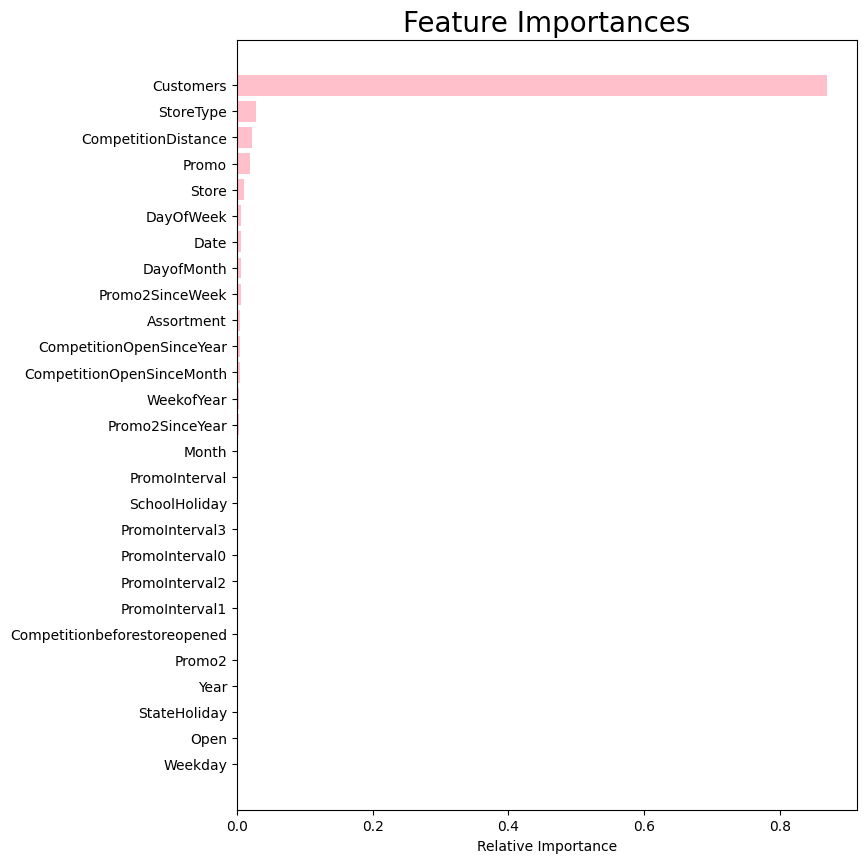

In [ ]:
features = xl_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='pink', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# LSTM model

In [ ]:
data = dfd.groupby("Date").agg({"Sales": "mean"})
data

,Sales
Date,
2014-04-17,9085.548780
2014-04-18,84.268041
2014-04-19,7336.858871
2014-04-20,74.515625
2014-04-21,162.805310
2014-04-22,5897.436275
2014-04-23,5610.492958
2014-04-24,5306.750000
2014-04-25,5288.170940


In [ ]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data)
data['DataScaled'] = scaled_array

In [ ]:
SIZE = len(data.DataScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [ ]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.DataScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (375, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (375,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([375, 1])

In [ ]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [ ]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [ ]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [ ]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

# Model Training

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 8)             │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533 (2.08 KB)

 Trainable params: 533 (2.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
# Change 'huber_loss' to 'huber'
model.compile(loss="huber", optimizer='adam')

In [ ]:
mlflow.set_experiment("LSTM")
mlflow.tensorflow.autolog()
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

2024/10/27 15:32:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc70649e0eb340c288324edacf552a50', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/200
      1/Unknown 4s 4s/step - loss: 0.3988

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3988 - val_loss: 0.3844
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.3983

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - loss: 0.3983 - val_loss: 0.3837
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.3978

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.3978 - val_loss: 0.3831
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3974

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.3974 - val_loss: 0.3824
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3970

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.3970 - val_loss: 0.3816
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.3966

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.3966 - val_loss: 0.3809
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3962

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3962 - val_loss: 0.3802
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3958

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.3958 - val_loss: 0.3794
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3954

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.3954 - val_loss: 0.3787
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3949

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3949 - val_loss: 0.3779
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.3945

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.3945 - val_loss: 0.3771
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.3941

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.3941 - val_loss: 0.3764
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3937

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.3937 - val_loss: 0.3756
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3933

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3933 - val_loss: 0.3748
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3930

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.3930 - val_loss: 0.3740
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.3926

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3926 - val_loss: 0.3732
Epoch 17/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3922

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.3922 - val_loss: 0.3725
Epoch 18/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3919

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3919 - val_loss: 0.3717
Epoch 19/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3916

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3916 - val_loss: 0.3710
Epoch 20/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3913

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.3913 - val_loss: 0.3702
Epoch 21/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3910

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3910 - val_loss: 0.3695
Epoch 22/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3907

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.3907 - val_loss: 0.3688
Epoch 23/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3904

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.3904 - val_loss: 0.3681
Epoch 24/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.3902

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3902 - val_loss: 0.3675
Epoch 25/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.3900

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3900 - val_loss: 0.3668
Epoch 26/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3898

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.3898 - val_loss: 0.3662
Epoch 27/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3896

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.3896 - val_loss: 0.3656
Epoch 28/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.3894

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3894 - val_loss: 0.3651
Epoch 29/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3892

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.3892 - val_loss: 0.3646
Epoch 30/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3890

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.3890 - val_loss: 0.3640
Epoch 31/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.3888

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.3888 - val_loss: 0.3636
Epoch 32/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 0.3886

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - loss: 0.3886 - val_loss: 0.3631
Epoch 33/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.3884

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.3884 - val_loss: 0.3627
Epoch 34/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 0.3882

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 0.3882 - val_loss: 0.3622
Epoch 35/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3880

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.3880 - val_loss: 0.3618
Epoch 36/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.3878

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - loss: 0.3878 - val_loss: 0.3615
Epoch 37/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.3876

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 0.3876 - val_loss: 0.3611
Epoch 38/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.3874

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.3874 - val_loss: 0.3607
Epoch 39/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3871

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.3871 - val_loss: 0.3604
Epoch 40/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.3869

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.3869 - val_loss: 0.3600
Epoch 41/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3867

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.3867 - val_loss: 0.3597
Epoch 42/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3865

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.3865 - val_loss: 0.3594
Epoch 43/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.3862

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.3862 - val_loss: 0.3590
Epoch 44/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.3860

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.3860 - val_loss: 0.3587
Epoch 45/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.3858

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.3858 - val_loss: 0.3583
Epoch 46/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3855

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.3855 - val_loss: 0.3580
Epoch 47/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3853

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.3853 - val_loss: 0.3576
Epoch 48/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.3851

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.3851 - val_loss: 0.3572
Epoch 49/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.3848

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3848 - val_loss: 0.3568
Epoch 50/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3846

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3846 - val_loss: 0.3563
Epoch 51/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3843

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.3843 - val_loss: 0.3559
Epoch 52/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3841

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3841 - val_loss: 0.3554
Epoch 53/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3838

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3838 - val_loss: 0.3550
Epoch 54/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3835

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3835 - val_loss: 0.3545
Epoch 55/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.3832

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.3832 - val_loss: 0.3539
Epoch 56/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3830

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.3830 - val_loss: 0.3534
Epoch 57/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3827

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.3827 - val_loss: 0.3528
Epoch 58/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3824

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.3824 - val_loss: 0.3523
Epoch 59/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.3821

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.3821 - val_loss: 0.3517
Epoch 60/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.3818 - val_loss: 0.3511
Epoch 61/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3815

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.3815 - val_loss: 0.3504
Epoch 62/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.3812 - val_loss: 0.3498
Epoch 63/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3808

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.3808 - val_loss: 0.3492
Epoch 64/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3805

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.3805 - val_loss: 0.3485
Epoch 65/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3802

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3802 - val_loss: 0.3479
Epoch 66/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.3798

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3798 - val_loss: 0.3473
Epoch 67/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3795

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3795 - val_loss: 0.3466
Epoch 68/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.3791

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.3791 - val_loss: 0.3460
Epoch 69/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3788

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3788 - val_loss: 0.3454
Epoch 70/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3784

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3784 - val_loss: 0.3447
Epoch 71/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3781

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.3781 - val_loss: 0.3441
Epoch 72/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.3777

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.3777 - val_loss: 0.3434
Epoch 73/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.3773

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3773 - val_loss: 0.3428
Epoch 74/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.3769

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.3769 - val_loss: 0.3421
Epoch 75/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.3765

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - loss: 0.3765 - val_loss: 0.3415
Epoch 76/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.3761

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.3761 - val_loss: 0.3408
Epoch 77/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.3757

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 0.3757 - val_loss: 0.3401
Epoch 78/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 0.3753

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - loss: 0.3753 - val_loss: 0.3394
Epoch 79/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 0.3749

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - loss: 0.3749 - val_loss: 0.3386
Epoch 80/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.3745

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.3745 - val_loss: 0.3379
Epoch 81/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3741

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3741 - val_loss: 0.3371
Epoch 82/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3736

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.3736 - val_loss: 0.3363
Epoch 83/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3732

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3732 - val_loss: 0.3355
Epoch 84/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3728

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3728 - val_loss: 0.3347
Epoch 85/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3723

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.3723 - val_loss: 0.3338
Epoch 86/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.3719

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.3719 - val_loss: 0.3330
Epoch 87/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3715

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.3715 - val_loss: 0.3322
Epoch 88/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3710

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3710 - val_loss: 0.3314
Epoch 89/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.3706

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.3706 - val_loss: 0.3306
Epoch 90/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3702

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3702 - val_loss: 0.3298
Epoch 91/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3697

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3697 - val_loss: 0.3290
Epoch 92/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3693

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3693 - val_loss: 0.3282
Epoch 93/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3689

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3689 - val_loss: 0.3274
Epoch 94/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3684

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.3684 - val_loss: 0.3266
Epoch 95/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.3680

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.3680 - val_loss: 0.3258
Epoch 96/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3675

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3675 - val_loss: 0.3250
Epoch 97/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3671

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.3671 - val_loss: 0.3241
Epoch 98/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3666

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3666 - val_loss: 0.3233
Epoch 99/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.3662

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.3662 - val_loss: 0.3225
Epoch 100/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.3657

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.3657 - val_loss: 0.3216
Epoch 101/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.3653

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.3653 - val_loss: 0.3208
Epoch 102/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3648

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3648 - val_loss: 0.3200
Epoch 103/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.3643

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.3643 - val_loss: 0.3191
Epoch 104/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3639

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3639 - val_loss: 0.3183
Epoch 105/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.3634

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.3634 - val_loss: 0.3175
Epoch 106/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3629

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3629 - val_loss: 0.3168
Epoch 107/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3624

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.3624 - val_loss: 0.3160
Epoch 108/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3619

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3619 - val_loss: 0.3152
Epoch 109/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.3614

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.3614 - val_loss: 0.3145
Epoch 110/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3608

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.3608 - val_loss: 0.3137
Epoch 111/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.3603

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.3603 - val_loss: 0.3130
Epoch 112/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3598

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.3598 - val_loss: 0.3122
Epoch 113/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3592

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3592 - val_loss: 0.3114
Epoch 114/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3586

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.3586 - val_loss: 0.3107
Epoch 115/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.3581

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.3581 - val_loss: 0.3099
Epoch 116/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3575

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3575 - val_loss: 0.3091
Epoch 117/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.3568

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.3568 - val_loss: 0.3084
Epoch 118/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3562

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3562 - val_loss: 0.3076
Epoch 119/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3556

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.3556 - val_loss: 0.3069
Epoch 120/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.3549

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.3549 - val_loss: 0.3061
Epoch 121/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.3543

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.3543 - val_loss: 0.3054
Epoch 122/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 0.3536

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 0.3536 - val_loss: 0.3048
Epoch 123/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.3529

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 0.3529 - val_loss: 0.3041
Epoch 124/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3522

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.3522 - val_loss: 0.3035
Epoch 125/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 0.3515

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: 0.3515 - val_loss: 0.3029
Epoch 126/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3508

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.3508 - val_loss: 0.3024
Epoch 127/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.3500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.3500 - val_loss: 0.3019
Epoch 128/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3493

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.3493 - val_loss: 0.3015
Epoch 129/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.3485

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.3485 - val_loss: 0.3009
Epoch 130/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.3478

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.3478 - val_loss: 0.3002
Epoch 131/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.3470

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3470 - val_loss: 0.2994
Epoch 132/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3462

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3462 - val_loss: 0.2984
Epoch 133/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3454

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3454 - val_loss: 0.2972
Epoch 134/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3446

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3446 - val_loss: 0.2959
Epoch 135/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3437

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.3437 - val_loss: 0.2945
Epoch 136/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3428

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3428 - val_loss: 0.2931
Epoch 137/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3419

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3419 - val_loss: 0.2917
Epoch 138/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3410

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.3410 - val_loss: 0.2903
Epoch 139/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3401

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.3401 - val_loss: 0.2890
Epoch 140/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3391

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.3391 - val_loss: 0.2878
Epoch 141/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3382

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.3382 - val_loss: 0.2866
Epoch 142/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3372

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.3372 - val_loss: 0.2855
Epoch 143/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3362

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.3362 - val_loss: 0.2845
Epoch 144/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3352

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.3352 - val_loss: 0.2836
Epoch 145/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3341

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3341 - val_loss: 0.2827
Epoch 146/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.3331

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.3331 - val_loss: 0.2819
Epoch 147/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3320

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.3320 - val_loss: 0.2812
Epoch 148/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3309

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3309 - val_loss: 0.2804
Epoch 149/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3298

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3298 - val_loss: 0.2795
Epoch 150/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.3286

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3286 - val_loss: 0.2786
Epoch 151/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.3275

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.3275 - val_loss: 0.2777
Epoch 152/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.3263

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.3263 - val_loss: 0.2766
Epoch 153/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3251

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.3251 - val_loss: 0.2756
Epoch 154/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3239

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3239 - val_loss: 0.2744
Epoch 155/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.3227

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.3227 - val_loss: 0.2733
Epoch 156/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3215

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.3215 - val_loss: 0.2722
Epoch 157/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3203

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.3203 - val_loss: 0.2711
Epoch 158/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3190

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3190 - val_loss: 0.2700
Epoch 159/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.3178

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.3178 - val_loss: 0.2690
Epoch 160/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.3165

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.3165 - val_loss: 0.2680
Epoch 161/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3152

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.3152 - val_loss: 0.2671
Epoch 162/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3140

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.3140 - val_loss: 0.2661
Epoch 163/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.3127

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.3127 - val_loss: 0.2651
Epoch 164/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.3114

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3114 - val_loss: 0.2640
Epoch 165/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.3101

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.3101 - val_loss: 0.2630
Epoch 166/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.3088

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 0.3088 - val_loss: 0.2618
Epoch 167/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.3074

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.3074 - val_loss: 0.2606
Epoch 168/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 0.3061

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 0.3061 - val_loss: 0.2594
Epoch 169/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.3048

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - loss: 0.3048 - val_loss: 0.2581
Epoch 170/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3035

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.3035 - val_loss: 0.2568
Epoch 171/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.3021

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 0.3021 - val_loss: 0.2556
Epoch 172/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.3008

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.3008 - val_loss: 0.2543
Epoch 173/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 0.2994

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.2994 - val_loss: 0.2531
Epoch 174/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.2981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2981 - val_loss: 0.2519
Epoch 175/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2967

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.2967 - val_loss: 0.2507
Epoch 176/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2954

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.2954 - val_loss: 0.2496
Epoch 177/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2940

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2940 - val_loss: 0.2484
Epoch 178/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2926

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2926 - val_loss: 0.2473
Epoch 179/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2913

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.2913 - val_loss: 0.2461
Epoch 180/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2899

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.2899 - val_loss: 0.2449
Epoch 181/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2885

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2885 - val_loss: 0.2437
Epoch 182/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2871

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.2871 - val_loss: 0.2425
Epoch 183/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.2858

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.2858 - val_loss: 0.2414
Epoch 184/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2844

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.2844 - val_loss: 0.2402
Epoch 185/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2830

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.2830 - val_loss: 0.2391
Epoch 186/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2816

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.2816 - val_loss: 0.2379
Epoch 187/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2802

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.2802 - val_loss: 0.2367
Epoch 188/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2788

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.2788 - val_loss: 0.2355
Epoch 189/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.2774

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2774 - val_loss: 0.2343
Epoch 190/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2760

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2760 - val_loss: 0.2330
Epoch 191/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.2746

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2746 - val_loss: 0.2318
Epoch 192/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2732

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2732 - val_loss: 0.2304
Epoch 193/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2718

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2718 - val_loss: 0.2291
Epoch 194/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2704

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.2704 - val_loss: 0.2276
Epoch 195/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2690

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.2690 - val_loss: 0.2259
Epoch 196/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2676

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.2676 - val_loss: 0.2241
Epoch 197/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.2662

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.2662 - val_loss: 0.2221
Epoch 198/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2648

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.2648 - val_loss: 0.2197
Epoch 199/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.2634

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2634 - val_loss: 0.2172
Epoch 200/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.2620

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - loss: 0.2620 - val_loss: 0.2144
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


In [ ]:
with open('lstm_model.pkl', 'wb') as f:
  pickle.dump(model, f)



In [ ]:

data.to_csv('prdiction of store sales task2.csv', index=False)